# Example of volume calculation

Volume calculation with bottom by reference to plan z = 4
Using breach telemac2d example

In [1]:
from data_manip.computation.volume import volume_calculation
from data_manip.extraction.telemac_file import TelemacFile

# Changing of directory : 'examples' directory of the Telemac sources
import os, sys
HOMETEL = os.environ.get('HOMETEL')

# defining the timestep number of extraction in the mesh file
itime = 0

# defining the name of the mesh file
my_mesh_file = os.path.join(HOMETEL, "examples", "telemac2d", "breach", "geo_breach.slf")

# loading the mesh file in an object TelemacFile
geo = TelemacFile(my_mesh_file)

# extracting connectivity array
ikle = geo.get_mesh_connectivity()

# extracting bottom from the mesh file 
try:
    bottom = geo.get_data_value('BOTTOM', itime)
except:
    bottom = geo.get_data_value('FOND', itime)

# extracting x and y coordinates from the mesh file
coord_x = geo.get_mesh_coord(1)
coord_y = geo.get_mesh_coord(2)

# defining the reference plan (e.g. Z = 4 m) which will be the reference to calculate the volume
zref = 4

# Calculating the volume of bathymetry relatively to plan Z = 4 m
volume_1, surface_point, volume_point = volume_calculation(ikle,
                                                           bottom,
                                                           coord_x,
                                                           coord_y,
                                                           x_ref=zref)

print(str(volume_1) + " m3")

geo.close()

580999.9785807761 m3


# Example of volume calculation 2

Volume of water calculation
Using breach telemac2d example

In [2]:
from data_manip.computation.volume import volume_calculation
from data_manip.extraction.telemac_file import TelemacFile

# Changing of directory : 'examples' directory of the Telemac sources
import os, sys
HOMETEL = os.environ.get('HOMETEL')

# defining the timestep number of extraction in the mesh file
itime = 0

# defining the name of the mesh file
my_mesh_file = os.path.join(HOMETEL, "examples", "telemac2d", "breach", "ini_breach.slf")

# loading the mesh file in an object TelemacFile
geo = TelemacFile(my_mesh_file)

# extracting connectivity array
ikle = geo.get_mesh_connectivity()

# extracting bottom from the mesh file
try:
    bottom = geo.get_data_value('BOTTOM', itime)
except:
    bottom = geo.get_data_value('FOND', itime)

    
# extracting free surface from the mesh file
# To get water depth, operation free surface - bottom is done
try:
    water_depth = geo.get_data_value('FREE SURFACE', itime) - bottom
except:
    water_depth = geo.get_data_value('SURFACE LIBRE', itime) - bottom

# keep only positive water depth (if negative ==> 0)
water_depth[water_depth < 0] = 0    

# extracting x and y coordinates from the mesh file
coord_x = geo.get_mesh_coord(1)
coord_y = geo.get_mesh_coord(2)

# Calculating the volume of water in the mesh
volume_w, surface_point, volume_point = volume_calculation(ikle,
                                                           water_depth,
                                                           coord_x,
                                                           coord_y)


print("Volume of water : " + str(volume_w) + " m3")

geo.close()

Volume of water : 271560.86835175403 m3


# Example of volume calculation 2

Volume calculation between 2 time steps with calculation in api mode

In [3]:
import numpy as np
from mpi4py import MPI

# Changing of directory : 'examples' directory of the Telemac sources
import os
HOMETEL = os.environ.get('HOMETEL')
os.chdir(os.path.join(HOMETEL, "examples", "telemac2d", "breach"))

from data_manip.extraction.telemac_file import TelemacFile
from data_manip.computation.volume import volume_calculation

# Instantiation of a Telemac2d object from the test case named 'breach'
# - steering file : 't2d_breach.cas'
# - language : french (1) or english (2: default)
from telapy.api.t2d import Telemac2d
my_case = Telemac2d('t2d_breach.cas', lang=1, comm=MPI.COMM_SELF)

# Reading case file
my_case.set_case()

# Initialisation of the calculation
my_case.init_state_default()

# Extracting water depth of the model initialisation
water_depth_0 = my_case.get_array('MODEL.WATERDEPTH')

# Extracting x and y coordinates from the model
coord_x = my_case.get_array('MODEL.X')
coord_y = my_case.get_array('MODEL.Y')

# Extracting connectivity array from the model
ikle = my_case.get_array('MODEL.IKLE') - 1
# Transpose of the connectivity array because ikle from Telemac is the transpose of ikle from mesh file
ikle = ikle.T

# Calculating the volume of water at T = 0s
volume_w0, surface_point, volume_point = volume_calculation(ikle,
                                                           water_depth_0,
                                                           coord_x,
                                                           coord_y)

# Execution of the calculation on 101 timesteps
for i in range(101):
    my_case.run_one_time_step()

water_depth_100 = my_case.get_array('MODEL.WATERDEPTH')

volume_w100, surface_point, volume_point = volume_calculation(ikle,
                                                           water_depth_100,
                                                           coord_x,
                                                           coord_y)

print("Volume of water at T = 0 : " + str(volume_w0) + " m3")
print("Volume of water at T = 100 : " + str(volume_w100) + " m3")

my_case.finalize()
del my_case

  ~> Checking keyword/rubrique coherence
 MASTER PROCESSOR NUMBER            0  OF THE GROUP OF            1
 READ_CONFIG: FILE CONFIG NOT FOUND: CONFIG
 DEFAULTS VALUES OF LU AND LNG:            6  AND            2
 LISTING OF TELEMAC2D------------------------------------------------------------------------------

                TTTTT  EEEEE  L      EEEEE  M   M  AAAAA  CCCCC
                  T    E      L      E      MM MM  A   A  C    
                  T    EEE    L      EEE    M M M  AAAAA  C    
                  T    E      L      E      M   M  A   A  C    
                  T    EEEEE  LLLLL  EEEEE  M   M  A   A  CCCCC
                                                               
                        2D    VERSION V8P5   FORTRAN 2003       







                        ~^~^~^~^~^~^~^~^~^~^~^^~^~^~^~^~^~     
                          ~                            ~       
                               \   '    o      '               
                               /\ o

 USING STREAMLINE VERSION V8P5 FOR CHARACTERISTICS


Volume of water at T = 0 : 271560.86835175403 m3
Volume of water at T = 100 : 270903.5431559253 m3





                     *************************************
                     *    END OF MEMORY ORGANIZATION:    *
                     *************************************




 CORRECT END OF RUN



 ELAPSE TIME : 
                              2  SECONDS


# Evolution of volume during a simulation (breach example)

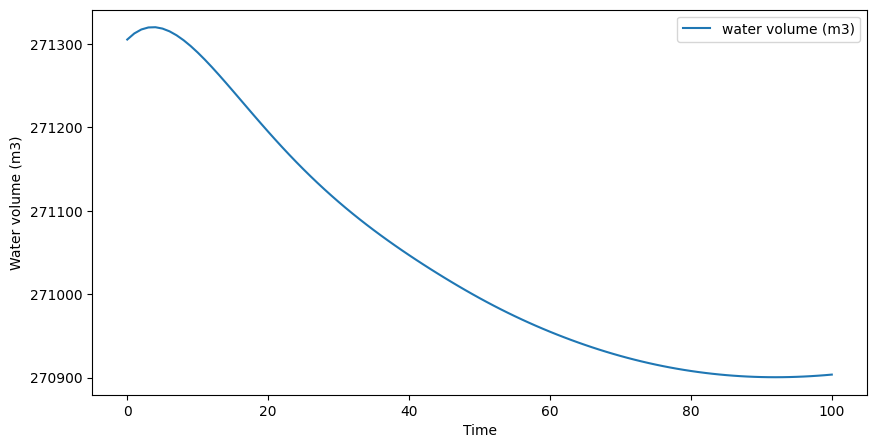

Volume of water at T = 0 : 271560.86835175403 m3
Volume of water at T = 100 : 270903.5431559253 m3



                     *************************************
                     *    END OF MEMORY ORGANIZATION:    *
                     *************************************




 CORRECT END OF RUN



 ELAPSE TIME : 
                             22  SECONDS


In [4]:
import numpy as np
from mpi4py import MPI

from IPython.display import clear_output, display
%matplotlib inline

from matplotlib import pyplot as plt
from postel.plot1d import plot1d


# Changing of directory : 'examples' directory of the Telemac sources
import os
HOMETEL = os.environ.get('HOMETEL')
os.chdir(os.path.join(HOMETEL, "examples", "telemac2d", "breach"))

from data_manip.extraction.telemac_file import TelemacFile
from data_manip.computation.volume import volume_calculation

# Instantiation of a Telemac2d object from the test case named 'breach'
# - steering file : 't2d_breach.cas'
# - language : french (1) or english (2: default)
from telapy.api.t2d import Telemac2d

my_mesh_file = "ini_breach.slf"
geo = TelemacFile(my_mesh_file)
ikle = geo.get_mesh_connectivity()
geo.close()

my_case = Telemac2d('t2d_breach.cas', lang=1, comm=MPI.COMM_SELF)

my_case.set_case()

my_case.init_state_default()

npoints = my_case.get('MODEL.NPOIN')

water_depth_0 = my_case.get_array('MODEL.WATERDEPTH')
coord_x = my_case.get_array('MODEL.X')
coord_y = my_case.get_array('MODEL.Y')


#ikle = my_case.get_array('MODEL.IKLE') - 1

volume_w0, surface_point, volume_point = volume_calculation(ikle,
                                                           water_depth_0,
                                                           coord_x,
                                                           coord_y)

times = []
volume_w = []

#Initialising figure
fig, ax = plt.subplots(figsize=(10,5))
plt.show()

for i in range(101):
    
    my_case.run_one_time_step()
    water_depth = my_case.get_array('MODEL.WATERDEPTH')
    volume, surface_point, volume_point = volume_calculation(ikle,
                                                            water_depth,
                                                            coord_x,
                                                            coord_y)
    times.append(i)
    volume_w.append(volume)
    clear_output(wait=True)
    
    ax.cla()
    plot1d(ax, times, volume_w, 'water volume (m3)', 'T = {}s'.format(times[i]))
    
    # Displaying legend
    ax.legend(loc='upper right')

    ax.set_xlabel('Time')
    ax.set_ylabel('Water volume (m3)')
    
    display(fig)


print("Volume of water at T = 0 : " + str(volume_w0) + " m3")
print("Volume of water at T = 100 : " + str(volume_w[100]) + " m3")

my_case.finalize()
del my_case

# Evolution of volume comparison and plot2d

 MASTER PROCESSOR NUMBER            0  OF THE GROUP OF            1
 READ_CONFIG: FILE CONFIG NOT FOUND: CONFIG
 DEFAULTS VALUES OF LU AND LNG:            6  AND            2
 LISTING OF TELEMAC2D------------------------------------------------------------------------------

                TTTTT  EEEEE  L      EEEEE  M   M  AAAAA  CCCCC
                  T    E      L      E      MM MM  A   A  C    
                  T    EEE    L      EEE    M M M  AAAAA  C    
                  T    E      L      E      M   M  A   A  C    
                  T    EEEEE  LLLLL  EEEEE  M   M  A   A  CCCCC
                                                               
                        2D    VERSION V8P5   FORTRAN 2003       







                        ~^~^~^~^~^~^~^~^~^~^~^^~^~^~^~^~^~     
                          ~                            ~       
                               \   '    o      '               
                               /\ o       \  o                 
            

Volume difference between T = 0 and T = 100 : -657.3251958287437 m3
Positive volume difference between T = 0 and T = 100 : 700.4511446769683 m3
Negative volume difference between T = 0 and T = 100 : -1357.7763405056635 m3



                     *************************************
                     *    END OF MEMORY ORGANIZATION:    *
                     *************************************




 CORRECT END OF RUN



 ELAPSE TIME : 
                              1  SECONDS


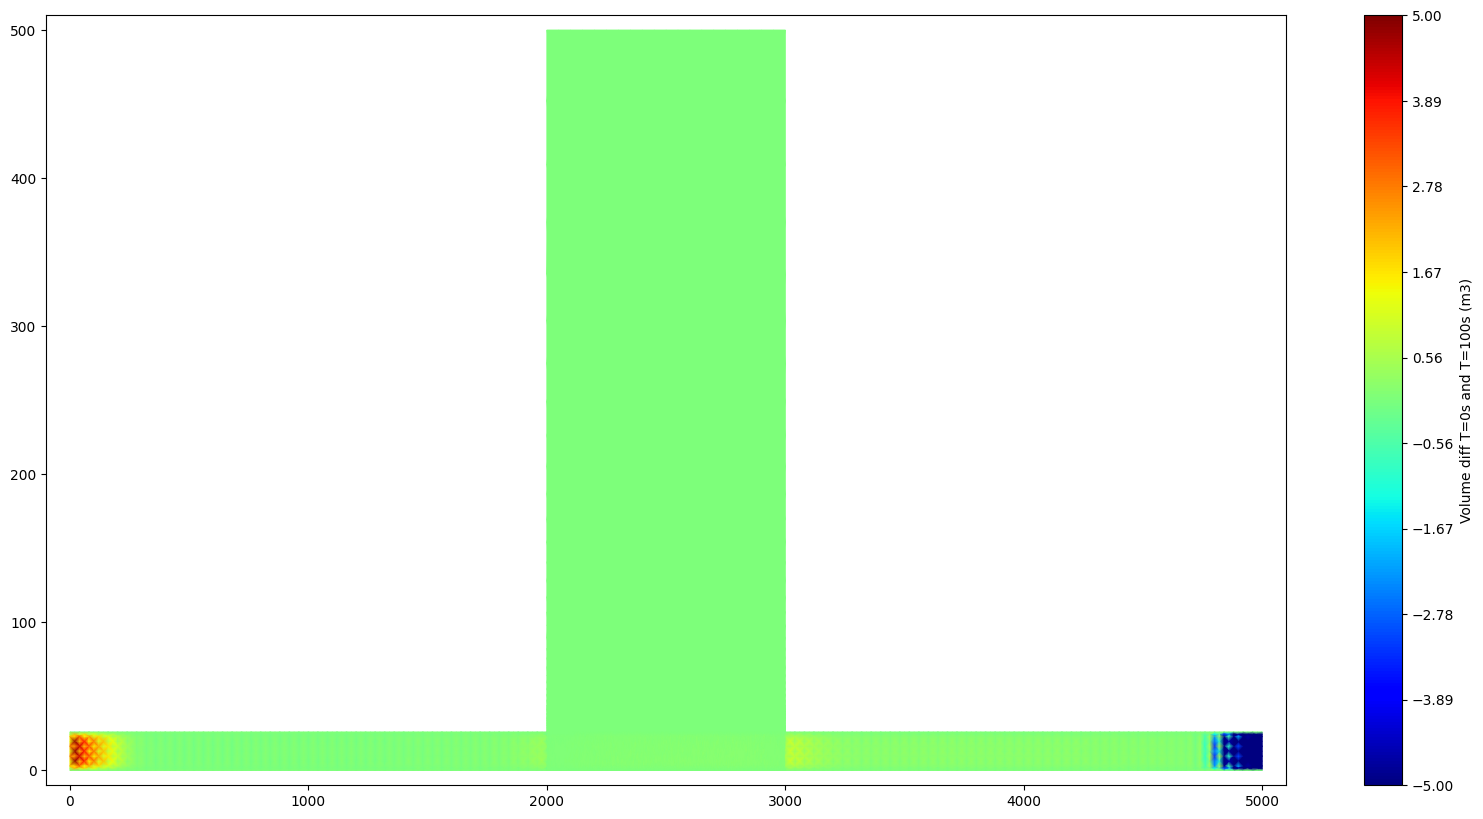

In [5]:
import numpy as np
from mpi4py import MPI

from IPython.display import clear_output
%matplotlib inline

from matplotlib import pyplot as plt
from postel.plot2d import *

# Changing of directory : 'examples' directory of the Telemac sources
import os
HOMETEL = os.environ.get('HOMETEL')
os.chdir(os.path.join(HOMETEL, "examples", "telemac2d", "breach"))

from data_manip.extraction.telemac_file import TelemacFile
from data_manip.computation.volume import volume_calculation

# Instantiation of a Telemac2d object from the test case named 'breach'
# - steering file : 't2d_breach.cas'
# - language : french (1) or english (2: default)
from telapy.api.t2d import Telemac2d

my_mesh_file = "ini_breach.slf"
geo = TelemacFile(my_mesh_file)
ikle = geo.get_mesh_connectivity()
geo.close()

my_case = Telemac2d('t2d_breach.cas', lang=1, comm=MPI.COMM_SELF)

my_case.set_case()

my_case.init_state_default()

npoints = my_case.get('MODEL.NPOIN')

water_depth_0 = my_case.get_array('MODEL.WATERDEPTH')
coord_x = my_case.get_array('MODEL.X')
coord_y = my_case.get_array('MODEL.Y')


#ikle = my_case.get_array('MODEL.IKLE') - 1

volume_w0, surface_point_w0, volume_point_w0 = volume_calculation(ikle,
                                                           water_depth_0,
                                                           coord_x,
                                                           coord_y)

for i in range(101):
    my_case.run_one_time_step()

    
water_depth = my_case.get_array('MODEL.WATERDEPTH')    
volume_w100, surface_point_w100, volume_point_w100 = volume_calculation(ikle,
                                                                        water_depth,
                                                                        coord_x,
                                                                        coord_y)

volume_diff = volume_w100 - volume_w0
volume_point_diff = volume_point_w100 - volume_point_w0
positive_volume_diff = volume_point_diff[volume_point_diff>0].sum()
negative_volume_diff = volume_point_diff[volume_point_diff<0].sum()

print("Volume difference between T = 0 and T = 100 : " + str(volume_diff) + " m3")
print("Positive volume difference between T = 0 and T = 100 : " + str(positive_volume_diff) + " m3")
print("Negative volume difference between T = 0 and T = 100 : " + str(negative_volume_diff) + " m3")

my_case.finalize()
del my_case

my_mesh_file = "ini_breach.slf"
geo = TelemacFile(my_mesh_file)
ikle = geo.get_mesh_connectivity()

# Initialising matplotlib figure
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plotting scalar map
plot2d_scalar_map(fig, ax, geo.tri, volume_point_diff, data_name='Volume diff T=0s and T=100s (m3)', vmin=-5, vmax=5, nv=10)

# Showing the plot
plt.show()

geo.close()